In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from torchsummary import summary

import matplotlib.pyplot as plt


# Debug SimCLR Model

In [2]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from src.models.unet3d.model_encoders import UNet3D


class SimCLR(pl.LightningModule):

    def __init__(self,
                 hidden_dim: int,
                 lr: float,
                 max_epochs: int,
                 img_dim: int,
                 temperature: float,
                 weight_decay: float,
                 encoder: UNet3D,
                 optimizer: torch.optim.Optimizer,
                 scheduler: torch.optim.lr_scheduler,
                 ):
        """_summary_

        Args:
            hidden_dim (int): number of neurons in the MLP head output aka dimensionality
                of feature vector
            lr (float): _description_
            img_dim (int): _description_
            temperature (float): _description_
            weight_decay (float): _description_
            encoder (UNet3D): _description_
            optimizer (torch.optim.Optimizer): _description_
            scheduler (torch.optim.lr_scheduler): _description_
        """
        super().__init__()
        self.save_hyperparameters(ignore=['net'])

        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # extract information about last layer embedding dimension
        number_of_layers = len(self.unet_encoder.f_maps)
        last_layer_kernels = self.unet_encoder.f_maps[-1]

        # calculate u-net embeding dimension after max pooling
        embed_dim = int(last_layer_kernels * ((img_dim/(2)**(number_of_layers - 1))**3)/(2**3))

        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.mlp_head = nn.Sequential(encoder,
                                      nn.MaxPool3d(kernel_size=2, stride=2),
                                      nn.Flatten(),
                                      nn.Linear(embed_dim, embed_dim),
                                      nn.ReLU(inplace=False),
                                      nn.Linear(embed_dim, hidden_dim))
        
        self.criterion = torch.nn.CrossEntropyLoss()
        
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def forward(self, x):
        return self.mlp_head(x)

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)
        # Encode all images
        features = self.mlp_head(imgs)
        
        labels = torch.cat([torch.arange(batch[-1].shape[0]) for i in range(2)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()

        features = F.normalize(features, dim=1)
        
        similarity_matrix = torch.matmul(features, features.T)
        
        # discard the main diagonal from both: labels and similarities matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        # assert similarity_matrix.shape == labels.shape

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long)
        logits = logits / self.hparams.temperature
        
        loss = self.criterion(logits, labels)

        # # Calculate cosine similarity
        # cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)

        # # Mask out cosine similarity to itself
        # self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        # cos_sim.masked_fill_(self_mask, -9e15)

        # # Find positive example -> batch_size//2 away from the original example
        # pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)

        # # InfoNCE loss
        # cos_sim = cos_sim / self.hparams.temperature
        # nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        # nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', loss, prog_bar=True)
        top1, top5 = self.accuracy(logits, labels, topk=(1, 5))
        # # Get ranking position of positive example
        # comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
        #                       cos_sim.masked_fill(pos_mask, -9e15)],
        #                      dim=-1)
        # sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

        # # Logging ranking metrics
        self.log(mode+'_acc_top1', top1[0],
                 prog_bar=True)
        self.log(mode+'_acc_top5', top5[0],
                 prog_bar=True)
        # self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        # return nll
    @staticmethod
    def accuracy(output, target, topk=(1,)):
        """Computes the accuracy over the k top predictions for the specified values of k"""
        with torch.no_grad():
            maxk = max(topk)
            batch_size = target.size(0)

            _, pred = output.topk(maxk, 1, True, True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            res = []
            for k in topk:
                correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
                res.append(correct_k.mul_(100.0 / batch_size))
            return res
    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')


# Debug DataModule

In [65]:
import os
import random
import logging
from pathlib import Path

import torch
import numpy as np
import SimpleITK as sitk
import torch.utils.data as data
from pytorch_lightning import LightningDataModule
from monai.transforms import Affine

from src.utils.general import resample_volume
from src.data.splits import synthseg_sst_splits

logger = logging.getLogger(__name__)

# path to synstheg generated images and label maps folders
sytnthseg_orig_path = Path(os.environ['SYNTHSEG_PATH'])
sytnthseg2x2x2_path = Path(os.environ['SYNTHSEG2x2x2_PATH'])


class ContrastiveDataSet(data.Dataset):
    def __init__(self,
                 dataset: str,
                 split: str,
                 nviews:int = 2,
                 use_2x2x2_preproc: bool = True,
                 skull_strip: bool | float = True,
                 resample: list[float] | None = None,
                 ):
        """ContrastiveDataSet

        Args:
            dataset (str): Which dataset to use for contrastive learning.
                Available datasets: 'synthseg'.
            nviews (int, optional): How many agumented images of the same labelmap tp load . Defaults to 2.
            split (srt): Train or validation split.
            skull_strip (bool|float, optional): Whether to load skull-stripped images or not. 
                If a float given, removes the skull with a given probability.
                Defaults to True (always removes the skull & face).
            resample (list[x, y, z] | None, optional): Resample the images to a given resolution.

        """
        self.dataset = dataset
        self.nviews = nviews
        self.skull_strip = skull_strip
        self.resample = list(resample) if resample is not None else None
        self.split = split
        self.use_2x2x2_preproc = use_2x2x2_preproc
        self.transfrom = Affine(scale_params=(1.5, 1.5, 1.5))
        if dataset == 'synthseg':
            self._load_synthseg()
        else:
            raise ValueError(f'Unknown dataset: {dataset}')

    def __getitem__(self, index):
        img_path = self.img_dirs[index]
        all_img_views = [x for x in img_path.glob('image*.nii.gz')]
        views_paths = [all_img_views[random.randint(0,len(all_img_views)-1)]\
                        for i in range(self.nviews)]

        views_images = self._load_images(views_paths)

        return (views_images, -1)

    def __len__(self):
        return len(self.img_dirs)

    def _load_synthseg(self):
        if self.use_2x2x2_preproc:
            sytnthseg_path = sytnthseg2x2x2_path
        else:
            sytnthseg_path = sytnthseg_orig_path

        self.img_dirs = [x for x in sytnthseg_path.iterdir() if x.is_dir()]

        if self.split == 'train':
            self.img_dirs = [x for x in self.img_dirs if x.name not in synthseg_sst_splits['val']]
        elif self.split == 'val':
            self.img_dirs = [x for x in self.img_dirs if x.name in synthseg_sst_splits['val']]

    def _load_images(self, views_paths):

        # load and convert to numpy
        images = [sitk.ReadImage(str(p)) for p in views_paths]
        images = [self._preporces_sitk(img) for img in images]
        images = [sitk.GetArrayFromImage(img) for img in images]

        # skull strip
        images = self._skull_strip(images, views_paths)

        # min-max normalization
        images = [(i - i.min())/(i.max() - i.min()) for i in images]

        # convert to torch tensors and return
        images = [torch.tensor(i, dtype=torch.float32) for i in images]

        # squeeze the channel dimension
        images = [i.unsqueeze(0) for i in images]
        # transformed = self.transfrom(images[0])[0].as_tensor()
        # images[1] = transformed
        return images

    def _skull_strip(self, images, image_paths):
        # load labels
        lable_paths = [str(x).replace('image', 'labels') for x in image_paths]
        labels = [sitk.ReadImage(p) for p in lable_paths]
        labels = [self._preporces_sitk(img, labelmap=True) for img in labels]
        labels = [sitk.GetArrayFromImage(img) for img in labels]

        # mask outeverything except cortex labels
        if self.skull_strip:
            # if skull_strip is a float, remove the skull with a given probability
            if isinstance(self.skull_strip, float) and 0.<= self.skull_strip <= 1.:
                if random.random() >= self.skull_strip:
                    return images
            # remove the skull and face and background
            cortex_mask = [((x < 500) & (x != 0)).astype(np.int16) for x in labels]
            
            masked_images = [x*y for x, y in zip(images, cortex_mask)]
            return masked_images
        else:
            # just remove the background
            cortex_mask = [(x != 0).astype(np.int16) for x in labels]
            masked_images = [x*y for x, y in zip(images, cortex_mask)]
            return masked_images

    def _preporces_sitk(self, img, labelmap=False):
        image_interpolator = sitk.sitkLinear if not labelmap else sitk.sitkNearestNeighbor
        if self.resample is not None:
            img = resample_volume(img, self.resample, image_interpolator)
            return img
        else:
            return img


class ContrastiveDataModule(LightningDataModule):
    def __init__(self,
                 dataset_cfg,
                 train_batch_size: int,
                 validation_batch_size: int,
                 num_workers: int) -> None:
        super().__init__()
        self.dataset_cfg = dataset_cfg
        self.train_batch_size = train_batch_size
        self.validation_batch_size = validation_batch_size
        self.num_workers = num_workers

        self.train_dataset = ContrastiveDataSet(**dataset_cfg, split='train')

        self.val_dataset = ContrastiveDataSet(**dataset_cfg, split='val')

        logger.info(f'Len of train examples {len(self.train_dataset)} ' +
                    f'len of validation examples {len(self.val_dataset)}')

    def train_dataloader(self):
        return data.DataLoader(self.train_dataset,
                               batch_size=self.train_batch_size,
                               shuffle=True,
                               num_workers=self.num_workers,
                               drop_last=True,
                               pin_memory=True)

    def val_dataloader(self):
        return data.DataLoader(
            self.val_dataset,
            batch_size=self.validation_batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            drop_last=False,
            pin_memory=True)


In [66]:
dm = ContrastiveDataModule({'dataset':'synthseg',
                                        'nviews':2, 'skull_strip':False,
                                        'resample':None,
                                        'use_2x2x2_preproc':True},2,2,1)

dl = data.DataLoader(
            dm.train_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=1,
            drop_last=False,
            pin_memory=False)

ds = dm.train_dataset

2023-03-14 14:10:42,486 - Len of train examples 16 len of validation examples 4


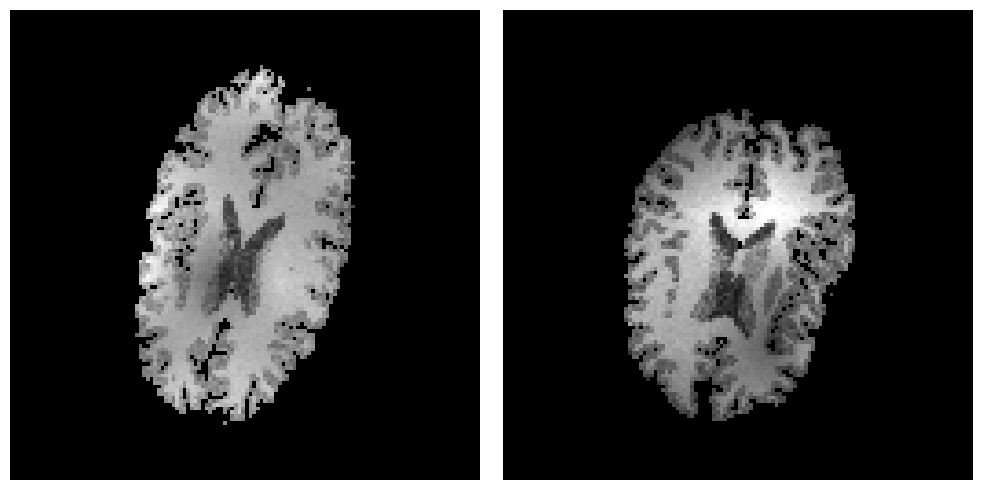

In [70]:
imgs = ds[6][0]

# plot the images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(imgs[0][0, :, 65, :], cmap='gray')
ax[1].imshow(imgs[1][0, :, 65, :], cmap='gray')

ax[0].grid(False)
ax[1].grid(False)
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

In [43]:
training_dl = iter(dl)

In [44]:
for i in range(1):
    imgs_batch, _ = next(training_dl)

KeyboardInterrupt: 

In [64]:
from monai.networks.nets.resnet import resnet18
import torch.nn as nn

In [54]:
resnet3d = resnet18(n_input_channels=1, spatial_dims=3,  pretrained=False)

In [56]:
resnet3d = resnet18(n_input_channels=1, spatial_dims=3,  pretrained=False)
pretrain = torch.load('/mrhome/vladyslavz/Downloads/nobackup/MedicalNet_pytorch_files2/pretrain/resnet_18.pth')
pretrain['state_dict'] = {k.replace('module.', ''): v for k, v in pretrain['state_dict'].items()}
resnet3d.load_state_dict(pretrain['state_dict'], strict=False)
resnet3d.fc = nn.Sequential(nn.Linear(512, 512),
                                      nn.ReLU(inplace=False),
                                      nn.Linear(512, 256))


_IncompatibleKeys(missing_keys=['layer2.0.downsample.0.weight', 'layer2.0.downsample.0.bias', 'layer2.0.downsample.1.weight', 'layer2.0.downsample.1.bias', 'layer2.0.downsample.1.running_mean', 'layer2.0.downsample.1.running_var', 'layer3.0.downsample.0.weight', 'layer3.0.downsample.0.bias', 'layer3.0.downsample.1.weight', 'layer3.0.downsample.1.bias', 'layer3.0.downsample.1.running_mean', 'layer3.0.downsample.1.running_var', 'layer4.0.downsample.0.weight', 'layer4.0.downsample.0.bias', 'layer4.0.downsample.1.weight', 'layer4.0.downsample.1.bias', 'layer4.0.downsample.1.running_mean', 'layer4.0.downsample.1.running_var', 'fc.weight', 'fc.bias'], unexpected_keys=[])

In [57]:
import torchsummary

In [60]:
torchsummary.summary(resnet3d.to('cuda'), (1, 128, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 64, 128, 128, 128]          21,952
       BatchNorm3d-2    [-1, 64, 128, 128, 128]             128
              ReLU-3    [-1, 64, 128, 128, 128]               0
         MaxPool3d-4       [-1, 64, 64, 64, 64]               0
            Conv3d-5       [-1, 64, 64, 64, 64]         110,592
       BatchNorm3d-6       [-1, 64, 64, 64, 64]             128
              ReLU-7       [-1, 64, 64, 64, 64]               0
            Conv3d-8       [-1, 64, 64, 64, 64]         110,592
       BatchNorm3d-9       [-1, 64, 64, 64, 64]             128
             ReLU-10       [-1, 64, 64, 64, 64]               0
      ResNetBlock-11       [-1, 64, 64, 64, 64]               0
           Conv3d-12       [-1, 64, 64, 64, 64]         110,592
      BatchNorm3d-13       [-1, 64, 64, 64, 64]             128
             ReLU-14       [-1, 64, 64,

In [65]:
resnet3d.fc = nn.Sequential(nn.Linear(512, 512),
                                      nn.ReLU(inplace=False),
                                      nn.Linear(512, 256))

In [66]:
torchsummary.summary(resnet3d.to('cuda'), (1, 128, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 64, 128, 128, 128]          21,952
       BatchNorm3d-2    [-1, 64, 128, 128, 128]             128
              ReLU-3    [-1, 64, 128, 128, 128]               0
         MaxPool3d-4       [-1, 64, 64, 64, 64]               0
            Conv3d-5       [-1, 64, 64, 64, 64]         110,592
       BatchNorm3d-6       [-1, 64, 64, 64, 64]             128
              ReLU-7       [-1, 64, 64, 64, 64]               0
            Conv3d-8       [-1, 64, 64, 64, 64]         110,592
       BatchNorm3d-9       [-1, 64, 64, 64, 64]             128
             ReLU-10       [-1, 64, 64, 64, 64]               0
      ResNetBlock-11       [-1, 64, 64, 64, 64]               0
           Conv3d-12       [-1, 64, 64, 64, 64]         110,592
      BatchNorm3d-13       [-1, 64, 64, 64, 64]             128
             ReLU-14       [-1, 64, 64,